In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

from config.config import Config
from src.data_loader import DataLoader
from src.pre_processing import PreProcessor
from src.feature_extraction import FeatureExtractor
from src.cache_manager import CacheManager
from src.models import ModelFactory

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("Imports OK")


Imports OK


In [2]:
config = Config()

FEATURE_SET = "xgb"
TEST_SIZE = 0.2
RANDOM_STATE = config.RANDOM_STATE
USE_DEFAULT_TRAIN_TEST_SPLIT = True

print(f"FEATURE_SET = {FEATURE_SET}")
print(f"TEST_SIZE = {TEST_SIZE}")
print(f"CACHE_FEATURES = {config.CACHE_FEATURES}")


FEATURE_SET = xgb
TEST_SIZE = 0.2
CACHE_FEATURES = True


In [3]:
loader = DataLoader()
preprocessor = PreProcessor()
feature_extractor = FeatureExtractor(feature_set=FEATURE_SET)
cache = CacheManager()
factory = ModelFactory()

metadata = loader.load_metadata()
print("Metadata loaded:", metadata.shape)
print(metadata.head(2))


Metadata loaded: (8732, 8)
      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  


In [4]:
if USE_DEFAULT_TRAIN_TEST_SPLIT:
    train_df = metadata[metadata["fold"] != config.TEST_FOLD].copy()
    test_df  = metadata[metadata["fold"] == config.TEST_FOLD].copy()
else:
    train_df, test_df = train_test_split(
        metadata,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=metadata["classID"]
    )

print("Train size:", len(train_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df["classID"].value_counts().sort_index().to_string())

print("\nTest class distribution:")
print(test_df["classID"].value_counts().sort_index().to_string())


Train size: 6985
Test size: 1747

Train class distribution:
classID
0    800
1    343
2    800
3    800
4    800
5    800
6    299
7    800
8    743
9    800

Test class distribution:
classID
0    200
1     86
2    200
3    200
4    200
5    200
6     75
7    200
8    186
9    200


In [5]:
def extract_X_y(df, feature_set: str):
    X, y = [], []

    for _, row in df.iterrows():
        audio_path = loader.get_audio_path(row["slice_file_name"], row["fold"])

        feats = cache.load_cached_features(audio_path, feature_set)
        if feats is None:
            audio, sr = preprocessor.load_and_preprocess(audio_path)
            feats = feature_extractor.extract_features(audio, sr)
            cache.save_cached_features(audio_path, feature_set, feats)

        X.append(feats)
        y.append(row["classID"])

    return np.array(X), np.array(y)

In [6]:
print("Extracting TRAIN features...")
X_train, y_train = extract_X_y(train_df, FEATURE_SET)
print("X_train:", X_train.shape, "y_train:", y_train.shape)

print("\nExtracting TEST features...")
X_test, y_test = extract_X_y(test_df, FEATURE_SET)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

print("\nFeature dimension:", X_train.shape[1])


Extracting TRAIN features...
X_train: (6985, 250) y_train: (6985,)

Extracting TEST features...
X_test: (1747, 250) y_test: (1747,)

Feature dimension: 250


In [7]:
xgb = factory.get_model("xgboost")
print(xgb)

xgb.fit(X_train, y_train)
print("Training complete")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=-1, num_class=10, ...)
Training complete


In [8]:
y_pred = xgb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

print("=" * 60)
print("XGBOOST TEST METRICS")
print("=" * 60)
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print("=" * 60)

print("\nClassification report:\n")
print(classification_report(
    y_test, y_pred,
    target_names=config.CLASS_NAMES,
    zero_division=0
))


XGBOOST TEST METRICS
Accuracy : 0.9153
Precision: 0.9171
Recall   : 0.9153
F1-score : 0.9156

Classification report:

                  precision    recall  f1-score   support

 air_conditioner       0.97      0.97      0.97       200
        car_horn       0.93      0.91      0.92        86
children_playing       0.88      0.89      0.89       200
        dog_bark       0.96      0.89      0.92       200
        drilling       0.88      0.92      0.90       200
   engine_idling       0.96      0.91      0.93       200
        gun_shot       0.84      0.96      0.89        75
      jackhammer       0.87      0.90      0.88       200
           siren       0.97      0.93      0.95       186
    street_music       0.88      0.91      0.90       200

        accuracy                           0.92      1747
       macro avg       0.91      0.92      0.91      1747
    weighted avg       0.92      0.92      0.92      1747



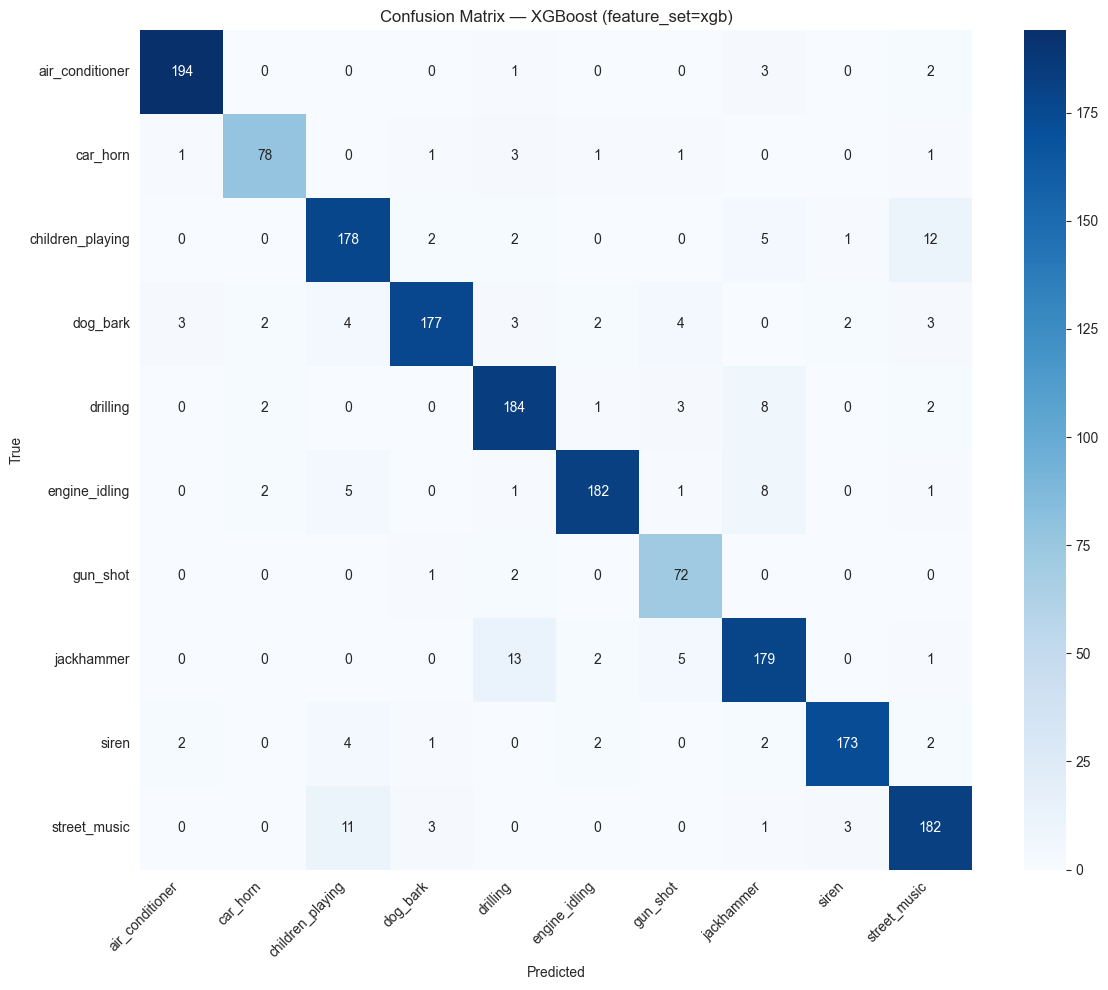

In [9]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=config.CLASS_NAMES,
    yticklabels=config.CLASS_NAMES
)
plt.title("Confusion Matrix — XGBoost (feature_set=xgb)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [11]:
wrong = (y_pred != y_test)
wrong_idx = np.where(wrong)[0]

print("Total wrong predictions:", len(wrong_idx))

#show mistakes
for i in wrong_idx:
    true_c = config.CLASS_NAMES[y_test[i]]
    pred_c = config.CLASS_NAMES[y_pred[i]]
    print(f"idx={i:4d} | true={true_c:16s} pred={pred_c:16s}")


Total wrong predictions: 148
idx=   7 | true=engine_idling    pred=children_playing
idx=  21 | true=engine_idling    pred=children_playing
idx=  43 | true=engine_idling    pred=jackhammer      
idx=  48 | true=dog_bark         pred=engine_idling   
idx=  50 | true=street_music     pred=jackhammer      
idx=  51 | true=children_playing pred=street_music    
idx=  89 | true=engine_idling    pred=jackhammer      
idx=  92 | true=dog_bark         pred=air_conditioner 
idx=  97 | true=car_horn         pred=dog_bark        
idx= 130 | true=air_conditioner  pred=street_music    
idx= 134 | true=children_playing pred=dog_bark        
idx= 139 | true=dog_bark         pred=children_playing
idx= 159 | true=dog_bark         pred=gun_shot        
idx= 168 | true=dog_bark         pred=car_horn        
idx= 171 | true=engine_idling    pred=children_playing
idx= 173 | true=jackhammer       pred=gun_shot        
idx= 174 | true=siren            pred=children_playing
idx= 189 | true=children_playing pre